In [1]:
import os

import numpy as np
import torch.nn.functional as F
import umap
import datasets
import torch
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModel

/Users/maxwoolf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Vision Model


In [2]:
processor = AutoImageProcessor.from_pretrained("nomic-ai/nomic-embed-vision-v1.5")
vision_model = AutoModel.from_pretrained(
    "nomic-ai/nomic-embed-vision-v1.5", trust_remote_code=True
)
_ = vision_model.eval()

/Users/maxwoolf/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


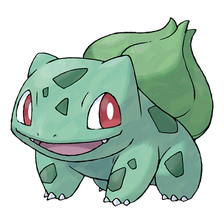

In [13]:
folder_name = "pokemon_images.nosync"

image_path = os.path.join(folder_name, "1.png")
image = Image.open(image_path)
image

In [4]:
def get_image_embedding(image):
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        img_emb = vision_model(**inputs).last_hidden_state
    img_embeddings = F.normalize(img_emb[:, 0], p=2, dim=1)
    return img_embeddings[0].cpu().detach().numpy()


get_image_embedding(image).shape

(768,)

## Load the Previously Generated Text Embeddings and Add Corresponding Image Embeddings


In [5]:
dataset = load_dataset("parquet", data_files="text_embeddings.parquet")["train"]

# embeddings must be numpy arrays
dataset.set_format(type="numpy", columns=["text_embedding"], output_all_columns=True)
dataset

Dataset({
    features: ['id', 'name', 'text_embedding'],
    num_rows: 1302
})

In [6]:
poke_dicts = []
na_embed = np.zeros((768,))

for poke in tqdm(dataset):
    image_path = os.path.join(folder_name, f"{poke["id"]}.png")

    if os.path.exists(image_path):
        poke_image = Image.open(image_path)
        embed = get_image_embedding(poke_image)
        poke_dicts.append(
            {
                "id": poke["id"],
                "text_embedding": poke["text_embedding"],
                "image_embedding": embed,
            }
        )
    else:
        poke_dicts.append(
            {
                "id": poke["id"],
                "text_embedding": poke["text_embedding"],
                "image_embedding": na_embed,
            }
        )

100%|██████████| 1302/1302 [01:35<00:00, 13.57it/s]


## Create a 2D Projection of the Concatenated Text + Image Embeddings

We concat both text and image embeddings (1536D total) so a 2D reduction can incorporate the information from both.

Some image embeddings are missing so just use an all-zero vector to substitute.


In [7]:
embeddings_concat = [
    np.hstack(
        (
            x["text_embedding"],
            x["image_embedding"],
        )
    )
    for x in poke_dicts
]
embeddings_concat = np.vstack(embeddings_concat)

embeddings_concat.shape

(1302, 1536)

In [8]:
reducer = umap.UMAP(n_components=2, n_epochs=5000)
embeddings_2d = reducer.fit_transform(embeddings_concat)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Update the existing Pokmon dicts with the reduced embeddings.

For ease of use in downstream data viz, put the `x` and `y` coordinates in separate fields.


In [9]:
for i, poke in tqdm(enumerate(poke_dicts)):
    poke["2d_x"] = embeddings_2d[i, 0]
    poke["2d_y"] = embeddings_2d[i, 1]

1302it [00:00, 2617921.29it/s]


Set up features for the final parquet output.


In [10]:
features = datasets.Features(
    {
        "id": datasets.Value(dtype="int32"),
        "text_embedding": datasets.Sequence(
            feature=datasets.Value(dtype="float32"), length=768
        ),
        "image_embedding": datasets.Sequence(
            feature=datasets.Value(dtype="float32"), length=768
        ),
        "2d_x": datasets.Value(dtype="float32"),
        "2d_y": datasets.Value(dtype="float32"),
    }
)

features

{'id': Value(dtype='int32', id=None),
 'text_embedding': Sequence(feature=Value(dtype='float32', id=None), length=768, id=None),
 'image_embedding': Sequence(feature=Value(dtype='float32', id=None), length=768, id=None),
 '2d_x': Value(dtype='float32', id=None),
 '2d_y': Value(dtype='float32', id=None)}

In [11]:
dataset_multimodal = datasets.Dataset.from_list(poke_dicts, features=features)
dataset_multimodal

Dataset({
    features: ['id', 'text_embedding', 'image_embedding', '2d_x', '2d_y'],
    num_rows: 1302
})

In [12]:
dataset_multimodal.to_parquet("pokemon_embeddings.parquet", compression="gzip")

Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00,  6.15ba/s]


8015112

## Push to the Hugging Face Hub
